\noindent __Erwann Rault__  
_Centre Oscar Lambret (Lille)_

In [1]:
# DRAW MATPLOTLIB IN NOTEBOOK #

%matplotlib inline
# %matplotlib notebook


In [3]:
# LIBRARIES #

import numpy as np
import pydicom as dcm
import matplotlib.pyplot as plt
import math
import time
import datetime

from scipy import ndimage
from ipywidgets import *

from openpyxl import load_workbook
from openpyxl.styles import Font, Color, colors

from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from os.path import basename

import warnings
warnings.filterwarnings('ignore')


In [22]:
# INPUT VARIABLES #

filepath = 'X:/Med Nuc/CQ TEP-CT/CQ CT/CQI 2019.04.11/'
nbOfFiles = 2

# Results written to:
excelFile ='C:/Users/00004436/Documents/GitHub/QCCT_HounsfieldNbs/QCCT_results.xlsx'
excelSheet = 'CQ CT'

# Cstes
margeROI = 5 #pix
radiusExtROIs = 50
sliceOfInterest80kV = 1
sliceOfInterest120kV = 0
thresholdPhantom = 0.5
refBruitROIcentraleInit80kV = 9.96# NM 10.48 
refBruitROIcentraleInit120kV = 5.49 # NM 5.53

# Acquisition information

In [23]:
# READS THE DICOM FILE #

# Get the file list
listFilesDCM = []  # creates an empty list
for dirName, subdirList, fileList in os.walk(filepath):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            listFilesDCM.append(os.path.join(dirName,filename))

# Get ref file
ds = dcm.read_file(listFilesDCM[0])

# Load dimensions:
nb_pixel_x = int(ds.Rows)
nb_pixel_y = int(ds.Columns)
nb_slices = len(listFilesDCM)
constPixDim = (nb_slices, nb_pixel_y, nb_pixel_x)
pixArray = np.zeros(constPixDim, dtype=np.float32)

# loop through all the DICOM files
for filenameDCM in listFilesDCM:
    dstmp = dcm.read_file(filenameDCM)
    try:
        rescaleIntercept = ds[0x0028,0x1052].value
        rescaleSlope = ds[0x0028,0x1053].value
    except KeyError:
        rescaleIntercept = 0
        rescaleSlope = 1
    pixArray[listFilesDCM.index(filenameDCM),:,:] = dstmp.pixel_array.astype(np.float32) * rescaleSlope + rescaleIntercept


In [24]:
# CONVERT DICOM TIME INFO TO DATETIME #

def convertToDatetime(date, time):
    year = int(int(date)/10000)
    month = int(int(date)/100-year*100)
    day = int(int(date)-year*10000-month*100)
    hour = int(float(time)/10000)
    minute = int(float(time)/100-hour*100)
    seconds =  int(float(time)-minute*100-hour*10000)
    return datetime.datetime(year, month, day, hour, minute, seconds)

In [25]:
# GET RELEVANT INFORMATION FROM DICOM FILE #

patient_name = ds.PatientName

study_date = ds.StudyDate
scan_time = ds[0x0008,0x0032].value
acq_datetime = convertToDatetime(study_date,scan_time)

print("Patient name: ", patient_name)
print("Patient ID: ", ds[0x0020,0x0010].value)
print("File name:", basename(filepath))
print(" ")
print("Scan date and time: ", acq_datetime)
print("Image size: {0} x {1} x {2}" .\
                format(constPixDim[2], constPixDim[1], constPixDim[0]))
print("Rescale slope:", rescaleSlope)
print("Rescale intercept:", rescaleIntercept)
print(" ")
print("System: ", ds[0x0008,0x0070].value)
print("        ", ds[0x0008,0x1010].value)


Patient name:  zzz_CQCT
Patient ID:  23275
File name: 
 
Scan date and time:  2019-04-11 17:10:40
Image size: 512 x 512 x 2
Rescale slope: 1
Rescale intercept: -1024.0
 
System:  GE MEDICAL SYSTEMS
         D690


# SUV calibration factor

In [26]:
# LAYOUT DEFINITIONS #

box_layout_std = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-start',
                    width='100%')

box_layout_right = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-end',
                    border='solid 0.5px #EEE',
                    width='100%')


In [27]:
# FINDS THE SUV PHANTOM IN THE IMAGE #

# function to find the phantom dimension and center in the image
def findPhantom(img, dimx, dimy, tp):
    com = ndimage.measurements.center_of_mass(img)
    #com = ndimage.measurements.maximum_position(img)
    
    comz = int(com[0])
    comy = int(com[1])
    comx = int(com[2])
    maxx = ndimage.measurements.maximum(img[comz,comy,:])
    x1 = 0
    while (img[comz,comy,x1]<maxx*tp):
        x1 = x1+1
    x2 = dimx-1
    while (img[comz,comy,x2]<maxx*tp):
        x2 = x2-1
    x1=x1-1
    x2=x2+1
    
    maxy = ndimage.measurements.maximum(img[comz,:,comx])
    y1 = 0
    while (img[comz,y1,comx]<maxy*tp):
        y1 = y1+1
    y2 = dimy-1
    while (img[comz,y2,comx]<maxy*tp):
        y2 = y2-1
    y1=y1-1
    y2=y2+1

    centerx = int(x1+(x2-x1)/2)
    centery = int(y1+(y2-y1)/2)
    
    if ((y2-y1)>(x2-1)):
        radius =(y2-y1)/2
    else:
        radius = (x2-x1)/2

    return [centerx, centery, radius]


In [28]:
# FUNCTION TO GET THE STATS INSIDE THE VOI #

def get_stats(img, dimx, dimy, centerx, centery, r, slicenb):
    l = []
    for j in range(0, dimy):
        for i in range(0, dimx):
            if (math.sqrt((i-centerx)*(i-centerx)+(j-centery)*(j-centery))<=r):
                l.append(img[slicenb,j,i])

    return np.mean(l), np.std(l)
    #return np.amin(l), np.amax(l), np.mean(l), np.std(l)

Box(children=(Label(value='Visualization window:'), FloatSlider(value=-100.0, description='min', max=136.0, mi…

Box(children=(Button(description='Refresh!', style=ButtonStyle()), Button(description='Save to excel file!', s…

Le rayon du fantome est 219.5 pixels
Le rayon de la ROI centrale est: 77 pixels
Le rayon des ROIs cardinales est: 50 pixels
   
Results for the slice nb 1 (80kV)
   
  central circle -> mean: -0.74  & std. dev: 10.69  (ref. : 9.96 )
  north circle -> mean: -3.65  & std. dev: 8.69
  south circle -> mean: -3.59  & std. dev: 8.54
  west circle -> mean: -3.39  & std. dev: 8.9
  east circle -> mean: -3.74  & std. dev: 8.9
  >>> Test succeeded ! 
   
Results for the slice nb 0 (120kV)
   
  central circle -> mean: -0.0  & std. dev: 5.68  (ref. : 5.49 )
  north circle -> mean: -0.91  & std. dev: 4.67
  south circle -> mean: -0.87  & std. dev: 4.69
  west circle -> mean: -0.85  & std. dev: 4.72
  east circle -> mean: -0.95  & std. dev: 4.73
  >>> Test succeeded ! 
   
   


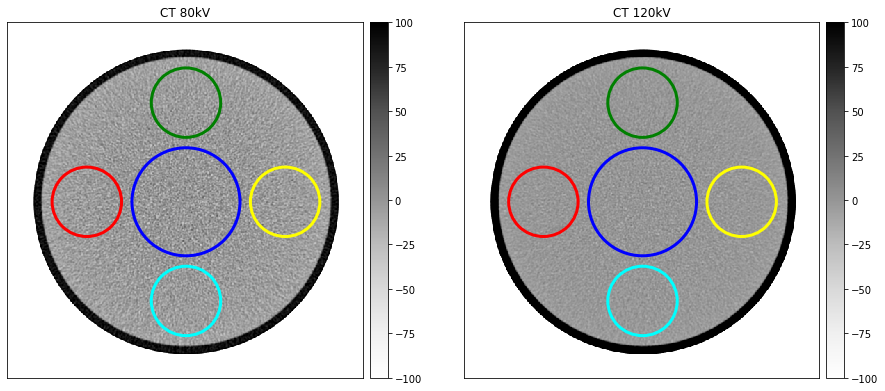

In [29]:
# MAIN INTERFACE #

# Displays SUV calculation results
def dispResults():
    c_mean, c_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value, 0.4*radius-2*margeROI, sliceOfInterest80kV)
    n_mean, n_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value-0.4*radius-radiusExtROIs-margeROI, radiusExtROIs, sliceOfInterest80kV)
    s_mean, s_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value+0.4*radius+radiusExtROIs+margeROI, radiusExtROIs, sliceOfInterest80kV)
    w_mean, w_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value-0.4*radius-radiusExtROIs-margeROI, 
                               yslider.value, radiusExtROIs, sliceOfInterest80kV)
    e_mean, e_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value+0.4*radius+radiusExtROIs+margeROI, 
                               yslider.value, radiusExtROIs, sliceOfInterest80kV)
    
    limitNoiseHU = 0.1 * refBruitROIcentraleInit80kV
    if (limitNoiseHU<0.2): limitNoiseHU = 0.2
    
    print('Le rayon du fantome est', radius, 'pixels')
    print('Le rayon de la ROI centrale est:', int(0.4*radius-10), 'pixels')
    print('Le rayon des ROIs cardinales est:', radiusExtROIs, 'pixels')
    print('   ') 
    print('Results for the slice nb', sliceOfInterest80kV, '(80kV)')
    print('   ') 
    print('  central circle -> mean:', round(c_mean,2),' & std. dev:', round(c_stddev,2), 
           ' (ref. :', refBruitROIcentraleInit80kV, ')') 
    print('  north circle -> mean:', round(n_mean,2),' & std. dev:', round(n_stddev,2))
    print('  south circle -> mean:', round(s_mean,2),' & std. dev:', round(s_stddev,2))
    print('  west circle -> mean:', round(w_mean,2),' & std. dev:', round(w_stddev,2))
    print('  east circle -> mean:', round(e_mean,2),' & std. dev:', round(e_stddev,2))
    if ((abs(c_mean)<4)and(abs(n_mean-c_mean)<4)and(abs(s_mean-c_mean)<4)and(abs(w_mean-c_mean)<4)
        and(abs(e_mean-c_mean)<4)and(abs(c_stddev-refBruitROIcentraleInit80kV)<limitNoiseHU)):
        print('  >>> Test succeeded ! ')
    else :
        print('  >>> Test Failed...')
    
    c_mean, c_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value, 0.4*radius-2*margeROI, sliceOfInterest120kV)
    n_mean, n_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value-0.4*radius-radiusExtROIs-margeROI, radiusExtROIs, sliceOfInterest120kV)
    s_mean, s_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value+0.4*radius+radiusExtROIs+margeROI, radiusExtROIs, sliceOfInterest120kV)
    w_mean, w_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value-0.4*radius-radiusExtROIs-margeROI, 
                               yslider.value, radiusExtROIs, sliceOfInterest120kV)
    e_mean, e_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value+0.4*radius+radiusExtROIs+margeROI, 
                               yslider.value, radiusExtROIs, sliceOfInterest120kV)
    
    limitNoiseHU = 0.1 * refBruitROIcentraleInit120kV
    if (limitNoiseHU<0.2): limitNoiseHU = 0.2
    
    print('   ') 
    print('Results for the slice nb', sliceOfInterest120kV, '(120kV)')
    print('   ') 
    print('  central circle -> mean:', round(c_mean,2),' & std. dev:', round(c_stddev,2), 
           ' (ref. :', refBruitROIcentraleInit120kV, ')') 
    print('  north circle -> mean:', round(n_mean,2),' & std. dev:', round(n_stddev,2))
    print('  south circle -> mean:', round(s_mean,2),' & std. dev:', round(s_stddev,2))
    print('  west circle -> mean:', round(w_mean,2),' & std. dev:', round(w_stddev,2))
    print('  east circle -> mean:', round(e_mean,2),' & std. dev:', round(e_stddev,2))
    if ((abs(c_mean)<4)and(abs(n_mean-c_mean)<4)and(abs(s_mean-c_mean)<4)and(abs(w_mean-c_mean)<4)
        and(abs(e_mean-c_mean)<4)and(abs(c_stddev-refBruitROIcentraleInit120kV)<limitNoiseHU)):
        print('  >>> Test succeeded ! ')
    else :
        print('  >>> Test Failed...')
    print('   ') 
    print('   ') 

    
# Save results to an excel file
def saveToXls(b):
    wb = load_workbook(excelFile)
    sheet = wb.get_sheet_by_name(excelSheet)

    maxrow = 5
    while (sheet['A'+str(maxrow)].value != None):
        maxrow = maxrow+1
    
    sheet['A'+str(maxrow)] = acq_datetime
    
    # image 80kV
    c_mean, c_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value, 0.4*radius-2*margeROI, sliceOfInterest80kV)
    n_mean, n_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value-0.4*radius-radiusExtROIs-margeROI, radiusExtROIs, sliceOfInterest80kV)
    s_mean, s_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value+0.4*radius+radiusExtROIs+margeROI, radiusExtROIs, sliceOfInterest80kV)
    w_mean, w_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value-0.4*radius-radiusExtROIs-margeROI, 
                               yslider.value, radiusExtROIs, sliceOfInterest80kV)
    e_mean, e_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value+0.4*radius+radiusExtROIs+margeROI, 
                               yslider.value, radiusExtROIs, sliceOfInterest80kV)

    ft = Font(color=colors.RED, bold = True)
    limitNoiseHU = 0.1 * sheet['H5'].value
    if (limitNoiseHU<0.2): limitNoiseHU = 0.2
    if abs(c_mean)>4:
        sheet['C'+str(maxrow)].font = ft
    sheet['C'+str(maxrow)] = float(c_mean)
    if abs(n_mean-c_mean)>4:
        sheet['D'+str(maxrow)].font = ft
    sheet['D'+str(maxrow)] = float(n_mean)
    if abs(s_mean-c_mean)>4:
        sheet['E'+str(maxrow)].font = ft
    sheet['E'+str(maxrow)] = float(s_mean)
    if abs(e_mean-c_mean)>4:
        sheet['F'+str(maxrow)].font = ft
    sheet['F'+str(maxrow)] = float(e_mean)
    if abs(w_mean-c_mean)>4:
        sheet['G'+str(maxrow)].font = ft
    sheet['G'+str(maxrow)] = float(w_mean)
    if abs(c_stddev-sheet['H5'].value)>limitNoiseHU:
        sheet['H'+str(maxrow)].font = ft
    sheet['H'+str(maxrow)] = float(c_stddev)
    
    # image 120kV
    c_mean, c_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value, 0.4*radius-2*margeROI, sliceOfInterest120kV)
    n_mean, n_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value-0.4*radius-radiusExtROIs-margeROI, radiusExtROIs, sliceOfInterest120kV)
    s_mean, s_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value, 
                               yslider.value+0.4*radius+radiusExtROIs+margeROI, radiusExtROIs, sliceOfInterest120kV)
    w_mean, w_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value-0.4*radius-radiusExtROIs-margeROI, 
                               yslider.value, radiusExtROIs, sliceOfInterest120kV)
    e_mean, e_stddev = get_stats(pixArray, nb_pixel_x, nb_pixel_y, xslider.value+0.4*radius+radiusExtROIs+margeROI, 
                               yslider.value, radiusExtROIs, sliceOfInterest120kV)
    
    limitNoiseHU = 0.1 * sheet['O5'].value
    if (limitNoiseHU<0.2): limitNoiseHU = 0.2
    if abs(c_mean)>4:
        sheet['J'+str(maxrow)].font = ft
    sheet['J'+str(maxrow)] = float(c_mean)
    if abs(n_mean-c_mean)>4:
        sheet['K'+str(maxrow)].font = ft
    sheet['K'+str(maxrow)] = float(n_mean)
    if abs(s_mean-c_mean)>4:
        sheet['L'+str(maxrow)].font = ft
    sheet['L'+str(maxrow)] = float(s_mean)
    if abs(e_mean-c_mean)>4:
        sheet['M'+str(maxrow)].font = ft
    sheet['M'+str(maxrow)] = float(e_mean)
    if abs(w_mean-c_mean)>4:
        sheet['N'+str(maxrow)].font = ft
    sheet['N'+str(maxrow)] = float(w_mean)
    if abs(c_stddev-sheet['O5'].value)>limitNoiseHU:
        sheet['O'+str(maxrow)].font = ft
    sheet['O'+str(maxrow)] = float(c_stddev)

    wb.save(excelFile)
    
    
    
# Draws circle centers
def redrawCenters():
    c1.center = (xslider.value, yslider.value)
    c2.center = (xslider.value-0.4*radius-radiusExtROIs-margeROI, yslider.value)
    c3.center = (xslider.value+0.4*radius+radiusExtROIs+margeROI, yslider.value)
    c4.center = (xslider.value, yslider.value-0.4*radius-radiusExtROIs-margeROI)
    c5.center = (xslider.value, yslider.value+0.4*radius+radiusExtROIs+margeROI)
    c6.center = (xslider.value, yslider.value)
    c7.center = (xslider.value-0.4*radius-radiusExtROIs-margeROI, yslider.value)
    c8.center = (xslider.value+0.4*radius+radiusExtROIs+margeROI, yslider.value)
    c9.center = (xslider.value, yslider.value-0.4*radius-radiusExtROIs-margeROI)
    c10.center = (xslider.value, yslider.value+0.4*radius+radiusExtROIs+margeROI)
    
def refreshPlot(b):    
    minv = minslider.value
    maxv = maxslider.value
    if (minv>maxv):
        print("Erreur: min > max")
    else:
        im1.set_data(pixArray[sliceOfInterest80kV,:,:])
        im1.set_clim(vmin=minv, vmax=maxv)
        im2.set_data(pixArray[sliceOfInterest120kV,:,:])
        im2.set_clim(vmin=minv, vmax=maxv)
    redrawCenters()
    display.clear_output(wait=True)
    display.display(fig)
    dispResults()
  
# Plot size
plt.rcParams['figure.figsize'] = (15,9)

# min, max of main image:
_min, _max = np.amin(pixArray), np.amax(pixArray)

# Ipywidgets:
minslider  = FloatSlider(value=-100, min=_min, max=_max, 
                         step=(_max-_min)/100, description='min', width='40%')
maxslider  = FloatSlider(value=100, min=_min, max=_max*1.5, 
                         step=(_max-_min)/100, description='max', width='40%')

xslider = IntSlider(value=int(nb_pixel_x/2), min=0, max=nb_pixel_x-1, 
                    step=1, description="x",width='40%')
yslider = IntSlider(value=int(nb_pixel_y/2), min=0, max=nb_pixel_y-1, 
                    step=1, description="y",width='40%')

refresh_button = Button(description="Refresh!", width='25%') #, height='100px'
refresh_button.on_click(refreshPlot)

save_button = Button(description="Save to excel file!", width='25%') #, height='100px'
save_button.on_click(saveToXls)

items1 = [
    Label(value="Visualization window:", width='90%'),
    minslider,
    maxslider,
    Label(value=". ", width='90%'),
    Label(value="Center:", width='90%'),
    xslider,
    yslider,
    Label(value=". ", width='90%'),
 ]
items2 = [
    refresh_button,
    save_button,
]

box1 = Box(children=items1, layout=box_layout_std)
box2 = Box(children=items2, layout=box_layout_right)
display.display(box1)
display.display(box2)

# Plots the images:
fig = plt.figure()
gs = gridspec.GridSpec(1,2)

centerx, centery, radius = findPhantom(pixArray, nb_pixel_x, nb_pixel_y,thresholdPhantom)
xslider.value = centerx
yslider.value = centery

ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(pixArray[sliceOfInterest80kV,:,:], cmap="Greys", vmin = -100, vmax = 100)
ax1.set_title('CT 80kV')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.axes.autoscale(False)

ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(pixArray[sliceOfInterest120kV,:,:], cmap="Greys", vmin = -100, vmax = 100)
ax2.set_title('CT 120kV')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.autoscale(False)

try:
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im1, cax=cax1)
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im2, cax=cax2)

    c1 = plt.Circle((xslider.value, yslider.value), 0.4*radius-2*margeROI, fill=False, 
                          color='blue', linewidth=3)
    ax1.axes.add_patch(c1)
    c2 = plt.Circle((xslider.value-0.4*radius-radiusExtROIs-margeROI, yslider.value), radiusExtROIs, fill=False, 
                          color='red', linewidth=3)
    ax1.axes.add_patch(c2)
    c3 = plt.Circle((xslider.value+0.4*radius+radiusExtROIs+margeROI, yslider.value), radiusExtROIs, fill=False, 
                          color='yellow', linewidth=3)
    ax1.axes.add_patch(c3)
    c4 = plt.Circle((xslider.value, yslider.value-0.4*radius-radiusExtROIs-margeROI), radiusExtROIs, fill=False, 
                          color='green', linewidth=3)
    ax1.axes.add_patch(c4)
    c5 = plt.Circle((xslider.value, yslider.value+0.4*radius+radiusExtROIs+margeROI), radiusExtROIs, fill=False, 
                          color='cyan', linewidth=3)
    ax1.axes.add_patch(c5)

    c6 = plt.Circle((xslider.value, yslider.value), 0.4*radius-2*margeROI, fill=False, 
                          color='blue', linewidth=3)
    ax2.axes.add_patch(c6)
    c7 = plt.Circle((xslider.value-0.4*radius-radiusExtROIs-margeROI, yslider.value), radiusExtROIs, fill=False, 
                          color='red', linewidth=3)
    ax2.axes.add_patch(c7)
    c8 = plt.Circle((xslider.value+0.4*radius+radiusExtROIs+margeROI, yslider.value), radiusExtROIs, fill=False, 
                          color='yellow', linewidth=3)
    ax2.axes.add_patch(c8)
    c9 = plt.Circle((xslider.value, yslider.value-0.4*radius-radiusExtROIs-margeROI), radiusExtROIs, fill=False, 
                          color='green', linewidth=3)
    ax2.axes.add_patch(c9)
    c10 = plt.Circle((xslider.value, yslider.value+0.4*radius+radiusExtROIs+margeROI), radiusExtROIs, fill=False, 
                          color='cyan', linewidth=3)
    ax2.axes.add_patch(c10)
except : 
    print('Error!')

dispResults()




# Remarks:

